In [4]:
import pandas
import numpy as np
import tomotopy as tp
import re
from pyvi import ViTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from scipy.stats import entropy
import pyLDAvis
from zingnews import crawNewsData
import requests

head = ['title', 'summary', 'date', 'categorys', 'content', 'url']
with open('data/vietnamese-stopwords-dash.txt',encoding='utf-8') as f:
    stop_words=f.read().splitlines()

Các hàm quan trọng

In [5]:
# đối tượng bài báo
class Doc():
    def __init__(self, title, summary, date, categorys, content, url, words):
        self.title = title
        self.summary = summary
        self.date = date
        self.categorys = categorys
        self.content = content
        self.url = url
        self.words = words
        
# đọc dữ liệu báo     
def load_docs(path):
    data = pandas.read_csv(path)
    docs = []
    for i in range(data.shape[0]):
        if not isinstance(data['words'][i], str):
            print(i, data['words'][i], data['title'][i])
            continue
            
        words = data['words'][i].split()
        if len(words) < 10:
            print(words)
            continue
        doc = Doc(data['title'][i], 
                  data['summary'][i], 
                  data['date'][i], 
                  data['categorys'][i], 
                  data['content'][i], 
                  data['url'][i], 
                  words)
        docs.append(doc)
    return docs

# hiển thị chủ đề bằng wordcloud
def show_wordcloud(dictionary):
    cloud = WordCloud(max_font_size=50, colormap="hsv", 
                      background_color="white").generate_from_frequencies(dictionary)
    plt.figure(figsize=(5,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()  
       
# phân cụm các bài báo vào chủ đề có xác suất cao nhất      
def get_clusters(model, train_docs, test_docs=None):
    clusters = [[] for _ in range(model.k)]

    for i, doc in enumerate(model.docs):
        k = doc.get_topics(1)[0][0]
        train_docs[i].topic_dist = doc.get_topic_dist()
        clusters[k].append((doc, train_docs[i]))
    if test_docs is not None:
        for doc_inf in test_docs:
            doc = model.make_doc(doc_inf.words)
            topic_dist, ll = model.infer(doc)
            doc_inf.topic_dist = topic_dist
            k = doc.get_topics(1)[0][0]
            clusters[k].append((doc, doc_inf))
        
    for i in clusters:
        print(len(i), end=' ')
    print()
    return clusters

# đo khoảng cách giữa 2 phân phối xác suất
def jensen_shannon(p, q):
    m = 0.5 * (p + q)
    return np.sqrt(0.5 * (entropy(p, m) + entropy(q, m)))

# tìm kiếm báo dựa trên văn bản đầu vào
def search_string(model, all_docs, search):
    search = re.split('\W+',ViTokenizer.tokenize(search).lower())
    search = [word for word in search if word not in stop_words and not word.isdigit()]
        
    doc_inst = model.make_doc(search)
    print(doc_inst)
    topic_dist, ll = model.infer(doc_inst)
    topic_dist = np.array(topic_dist)
    similarity = []
    for doc in all_docs:
        doc_topic_dist = np.array(doc.topic_dist)
        similarity.append(jensen_shannon(topic_dist, doc_topic_dist))
        
    similarity = sorted(enumerate(similarity), key=lambda s:s[1])
    for i, s in similarity[:10]:
        print(s)
        print(all_docs[i].title, all_docs[i].url)

# tính độ đo coherence của HDP model
def eval_coherence(model, corpus, vocab, word_list):  
    topics = []
    for k in range(model.k):
        if not model.is_live_topic(k): continue
        topic_words = [w for w, p in model.get_topic_words(k, top_n=10)]
        topics.append(topic_words)

    cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=vocab, texts=word_list, 
                        coherence='c_v')

    score = cm.get_coherence()
    return score

# tính độ đo coherence của LDA model
def eval_coherence_lda(model, corpus, vocab, word_list):  
    topics = []
    for k in range(model.k):
        topic_words = [w for w, p in model.get_topic_words(k, top_n=10)]
        topics.append(topic_words)

    cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=vocab, texts=word_list, 
                        coherence='c_v')

    score = cm.get_coherence()
    return score

# tính độ đo coherence của từng chủ đề với các bài báo được phân cụm vào nó
def eval_coherence_topic(model, clusters, k):
    word_list = [doc_inf.words for doc, doc_inf in clusters[k]]
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    topics = [[w for w, p in model.get_topic_words(k, top_n=10)]]
    cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=vocab, texts=word_list, 
                        coherence='c_v')

    score = cm.get_coherence()
    return score

<>:45: DeprecationWarning: invalid escape sequence \W
<>:92: DeprecationWarning: invalid escape sequence \W
<>:45: DeprecationWarning: invalid escape sequence \W
<>:92: DeprecationWarning: invalid escape sequence \W
<>:45: DeprecationWarning: invalid escape sequence \W
<>:92: DeprecationWarning: invalid escape sequence \W
<ipython-input-5-76f5d453711f>:45: DeprecationWarning: invalid escape sequence \W
  search = re.split('\W+',ViTokenizer.tokenize(search).lower())
<ipython-input-5-76f5d453711f>:92: DeprecationWarning: invalid escape sequence \W
  search = re.split('\W+',ViTokenizer.tokenize(search).lower())


Đọc dữ liệu

In [6]:
# đọc dữ liệu huấn luyện in ra các văn bản bị loại bỏ
docs = load_docs('data/zing_news_processed.csv')

['nhanh_chóng', 'sắp_xếp', 'đồ_đạc', 'dựng', 'lều', 'ưng_ý']
[]
[]
6003 nan khách_tây yêu làng nghèo hẻo_lánh của việt_nam
[]
[]
['thí_nghiệm', 'độ', 'thoáng_khí', 'airism', 'thí_nghiệm', 'độ', 'mềm', 'mịn', 'airism']
['nội_dung', 'viết', 'hình_ảnh', 'phòng', 'phẫu_thuật', 'độc_giả', 'vui_lòng', 'cân_nhắc']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['viết', 'hình_ảnh', 'sách', 'american', 'psyche', 'the_unlit_cave', 'nhiếp_ảnh', 'gia', 'george_elsasser']
['trung_kiên', 'infonet']
['ngoisao', 'vn']
[]
['lưu_ý', 'viết', 'tiết_lộ', 'nội_dung', 'mùa', 'stranger_things']
[]
[]
[]
[]
['sắp_xếp', 'năm_sinh']
['sắp_xếp', 'năm_sinh']
[]
[]
[]
[]
[]
['lê', 'hiếu', 'infonet']
['mời', 'bạn_đọc', 'tiếp', 'phần_mềm', 'pc', 'quá_khứ', 'bình_luận']
[]
[]
['lưu_ý', 'viết', 'tiết_lộ', 'toàn_bộ', 'nội_dung', 'phim', 'avengers', 'infinity_war']
['ty', 'bưu_điện', 'việt_nam']
['ty', 'bưu_điện', 'việt_nam']
['ảnh', 'obama', 'khoe', 'cún', 'cưng', 'ty', 'bưu_điện', 'việt_nam']
['vnexpress']
[]
['lưu_ý', 'viết', 't

In [12]:
# để tính coherence measure
word_list = [doc.words for doc in docs]
vocab = corpora.Dictionary(word_list)
corpus = [vocab.doc2bow(words) for words in word_list]

In [7]:
# đọc dữ liệu thử nghiệm in ra các văn bản bị loại bỏ
test_docs = load_docs('data/dantri_processed.csv')

['thế_anh']
['tuần', 'báo', 'tiền', 'hoàn_cảnh', 'danh_sách', 'chi_tiết']
['toạ_lạc', 'hẻm', 'nằm', 'tphcm', 'sở_hữu', 'gia_đình', 'trẻ', 'thảo_trinh']
['thảo', 'lê', 'archdaily']
['bích', 'ngọctheo', 'business_insider']
['dung_nhi', 'tw']
['hồng_minh']
['đỗ_quân']
['đỗ_quân']
['quốc_triều']
['quân_đỗ']
['xuân_sinh', 'phượng_vũ', 'tiến_hiệp']
['trần_thanh', 'quang_phong']
['thành_đạt', 'ảnh', 'reuters', 'đồ_họa', 'guardian']
['thành_đạt']
['đức', 'hoàng_ảnh', 'reuters', 'afp', 'rex']
['đức', 'hoàng_ảnh', 'reuters']
['đức', 'hoàng_ảnh', 'reuters', 'afp']
['thành_đạt', 'ảnh', 'reuters']
['đức', 'hoàng_ảnh', 'reuters', 'afp', 'ap', 'getty']
['dung_nhi', 'ts']
['đỗ_linh']
['thu_hương']
['chạy', 'bộ_môn', 'thi_đấu', 'ném', 'lao', 'nhảy_sào', 'nhảy_xa', 'diễn', 'đỗ_linh']
['tiến_tuấn', 'đỗ_linh']
['toàn_văn', 'thư', 'bộ_trưởng', 'đào_ngọc_dung']
['toàn_văn', 'thư']
['vtv', 'vn']
['tiến_hiệp']
['biên_dịch', 'cẩm_tú_đồ_hoạ', 'ngọc_diệp']
['tuần', 'báo', 'tiền', 'hoàn_cảnh', 'danh_sách', 'chi_t

['thùy_dương', 'hương_giang', 'đồ_họa', 'quỳnh_trang']
['toàn_vũ']
['thái_bá']
['vov']
['hải_phong', 'brightside']
['vtv', 'vn']
['đức', 'hoàng_ảnh', 'reuters', 'afp']
['thành_đạt', 'ảnh', 'reuters']
['thành_đạt', 'ảnh', 'afp', 'reuters']
['thành_đạt', 'ảnh', 'dailymail', 'rex', 'reuters']
['kiều_minh', 'gq']
['kiều_minh', 'jj']
['vĩnh_ngọc', 'dm']
['phượng_vũ', 'tiến_hiệp']
['hiệp', 'nguyễn_ảnh', 'video', 'quân_đỗ']
['hữu_nghị', 'đỗ_quân']
['tú_quyên']
['tú_quyên']
['tú_quyên']
['nguyễn_phê']
['t', 'v', 'dân', 'việt']
['t', 'v', 'dân', 'việt']
['an_an', 'dân', 'việt']
['trần_trang', 'dân', 'việt']
['t', 'v', 'dân', 'việt']
['dân', 'việt', 'parents']
['t', 'v', 'dân', 'việt']
['kiều_minh', 'jj']
['paris', 'pháp']
['quang_phong', 'tổng_hợp']
['bạn_đọc', 'minh_tuấn', 'tphcm']
['mạnh_thắng']
['phúcnguồn', 'video', 'ub', 'an_toàn', 'giao_thông', 'qg']
['phương', 'nhung_ảnh', 'video', 'mạnh_thắng']
['phương', 'nhung_ảnh', 'thành_đạt']
['ngọc_diệp', 'quang_phong']
['phú_thọ', 'công_bính']
['

['hạ_nhiên', 'dân', 'việt']
['hà_tùng_long']
['dương_triều_sinh_viên', 'việt_nam']
['hiệp', 'nguyễn']
['hiệp', 'nguyễn']
['quang_tùng', 'phạm_tiến', 'đỗ_ngọc_diệp']
['ub', 'an_toàn', 'giao_thông', 'qg']
['ngọc_diệp']
['dung_nhi', 'br']
['kim_bảo', 'ngân', 'ảnh', 'hồ', 'đức_việt']
['dung_nhi', 'br']
['trà_xanh', 'bp']
['băng_châu', 'ảnh', 'louis_wu']
['h', 'k', 'ảnh', 'hải', 'lê_cao']
['phạm_xuân_bút']
['nguyễn_dương']
['hà_tùng', 'long_photo', 'chí_linh']
['khám_phá', 'món', 'đồ_chơi', 'khoa_học', 'thú_vị', 'video', 'thảo_vy', 'physicsfun']
['thảo_vy', 'bs']
['gia_hưng']
['xuân_ngọc']
['đức', 'hoàng', 'tổng_hợp']
['thành_đạt', 'ảnh', 'reuters']
['thư_quỳnh', 'nguyễn_quang']
['phương', 'nhung_ảnh', 'dee_cee']
['trung_kiên', 'nguyễn_hành']
['toàn_vũ']
['trường_thịnh']
['toàn_vũ']
['toàn_vũ']
['nhật_minh', 'video', 'youtube']
['thái_phương', 'lao_động']
['lý_giải', 'kim_long_city', 'liên_chiểu', 'dự_án', 'mong_đợi', 'quý', 'iv', 'mai_anh']
['hữu_thắng']
['khánh_hồng']
['gắn_bó', 'nghề', '

['băng_châu', 'tổng_hợp']
['hữu_nghị']
['hồng_minh']
['minh_phương', 'ảnh', 'reuters']
['vĩnh_ngọc', 'dm']
['an_bình', 'tổng_hợp']
['vĩnh_ngọc', 'pin']
['an_bình']
['an_bình']
['phương', 'nhung_ảnh', 'hải_bá']
['hà_tùng_long']
['phương', 'nhung_ảnh', 'huy_bình']
['đức', 'hoàng_ảnh', 'reuters', 'afp']
['an_bình']
['châu', 'như_quỳnh', 'tổng_hợp']
['thành_đạt', 'ảnh', 'reuters']
['thành_đạt', 'ảnh', 'reuters', 'korea_times']
['thành_đạt', 'ảnh', 'reuters']
['đức', 'hoàng', 'dailymail']
['quý_đoàn']
['nhật_minh', 'tổng_hợp']
['hải_yến', 'an_ninh', 'thủ_đô']
['phương', 'nhung_ảnh', 'trịnh_kim_điền']
['c', '_bính', 'n', '_linh']
['phương', 'nhung_ảnh', 'tuyết_nhung', 'cửu_long']
['phương_nhung']
['an', 'bình_ảnh', 'reuters']
['tiến_hiệp']
['thu_hằng', 'baotintuc', 'vn']
['toàn_vũ']
['thành_đạt', 'tổng_hợp']
['thu_trang', 'paris', 'pháp']
['ảnh', 'đinh_tuyết_mai', 'chlb', 'đức']
['đinh_tuyết_mai', 'chlb', 'đức']
['quân_đội', 'nhân_dân']
['đức', 'hoàng_ảnh', 'tass']
['đức', 'hoàng_ảnh', 'reut

In [14]:
# để tính coherence measure
test_word_list = [doc.words for doc in test_docs]
test_vocab = corpora.Dictionary(test_word_list)
test_corpus = [test_vocab.doc2bow(words) for words in test_word_list]

In [10]:
# số văn bản train và test
print(len(docs), len(test_docs))

41478 35748


In [8]:
# load model tốt nhất
lda = tp.LDAModel.load('model/lda_model_k_40.txt')

In [9]:
# phân cụm báo theo chủ đề
import time
c0 = time.time()
clusters = get_clusters(lda, docs, test_docs)
c1 = time.time()
print(c1-c0)

1488 1353 2076 1988 2306 971 1104 1049 2448 3142 2855 1621 1862 2731 1929 1314 2555 3634 994 2560 4518 2762 1011 1024 3167 2307 1592 637 2138 2917 548 1135 2008 1871 888 1358 2668 1790 1646 1261 
147.079327583313


In [12]:
for k in range(40):
    clusters[k] = sorted(clusters[k], key=lambda x:x[1].topic_dist[k])

Kết Quả

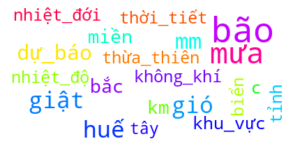

548
0. thiếu việc do covid 19 hướng_dẫn_viên tranh_thủ làm thêm việc khác
1. nóng kỷ_lục 38 độ c đảo_lộn hoàn_toàn cuộc_sống nơi lạnh nhất thế_giới
2. động_đất 7 5 độ ở mexico cảnh_báo sóng_thần với nhiều nước
3. mỹ hỗ_trợ việt_nam 2 triệu usd khắc_phục hậu_quả bão lũ
4. phận đời sau bão dữ nhà sập rồi ngày_mai biết đi về đâu 
5. 2 000 người sẵn_sàng chống ngập dịp quốc_khánh
6. wb thiên_tai có_thể cuốn sạch hàng tỷ usd tăng_trưởng của việt_nam
7. 10 kinh_nghiệm du_lịch mùa mưa bão
8. khách_sạn ở đà_nẵng dùng xe container chắn bão số 9
9. evn động_đất không khiến các công_trình điện bị ảnh_hưởng
10. hơn 4 giờ bão số 9 quần_thảo hội_an và tam_kỳ tan_hoang
11. người dân được ở khách_sạn miễn_phí để tránh siêu bão 
12. khách_sạn ở hội_an miễn_phí phòng cho người dân tránh bão số 9
13. ông kim_jong_un tới vùng hứng_chịu siêu bão haishen
14. vé máy_bay đi đà_nẵng đà_lạt tháng 10 còn hơn 1 triệu đồng
15. nắng_nóng khắc_nghiệt ở australia ô_tô biến thành lò nướng thịt lợn
16. thiên_thạch đang

In [23]:
# hiển thị các bài báo thuộc chủ đề k
k=30
show_wordcloud(dict(lda.get_topic_words(k, 20)))
print(len(clusters[k]))
for i, (doc, doc_inf) in enumerate(clusters[k]):
    print('{}. {}'.format(i, doc_inf.title))

In [36]:
# demo crawl từ url của bài báo, tiền xử lý và đưa ra các bài báo tương đồng
url = input()
try:
    response = requests.get(url)
    print('done')
    title, summary, date, categorys, content, url = crawNewsData(response, url)
    print(title)
    print(summary)
    print(date)
    print(categorys)
    search_string(lda, all_docs, content)
except:
    print("can't request")

https://zingnews.vn/bo-cong-an-hang-tram-nghin-nguoi-o-nuoc-ngoai-muon-ve-viet-nam-post1167895.html
done
Bộ Công an: Hàng trăm nghìn người ở nước ngoài muốn về Việt Nam
Theo đại tướng Tô Lâm, có 14.000 người nhập cảnh trái phép từ đầu năm đến nay; trong khi đó, hàng trăm nghìn người muốn về Việt Nam khi dịch Covid-19 diễn biến phức tạp.
Thứ ba, 29/12/2020 11:16 (GMT+7)
['Xã hội']
<tomotopy.Document with words="thông_tin đại_tướng tô_lâm bộ_trưởng công_an hội_nghị trực_tuyến chính_phủ địa_phương báo_cáo chính_phủ bộ_trưởng công_an tô_lâm nêu kiến_nghị định_hướng đại_tướng tô_lâm đề_nghị xây_dựng thể_chế xác_định đột_phá chiến_lược trung_ương chỉ_đạo nhiệm_vụ ý_nghĩa toàn dân ngành kỷ_cương kỷ_luật lâm tư_lệnh ngành công_an lực_lượng công_an công_tác xác_định trọng_tâm bộ_trưởng công_an kiến_nghị quốc_hội chính_phủ nội_dung công_tác xây_dựng thể_chế nội_dung công_an đề_xuất hai công_tác an_ninh kinh_tế bộ_trưởng công_an nhấn_mạnh ta phát_triển kinh_tế nền_tảng bảo_đảm an_ninh bối_cảnh hộ

In [28]:
# demo tìm kiếm báo dựa trên văn bản bất kì đưa vào
all_docs = docs + test_docs
search = input()
search_string(lda, all_docs,search)

bầu cử tổng thống
<tomotopy.Document with words="bầu_cử tổng_thống">
0.15860783650645413
nhà_trắng đổi nhân_sự cấp cao trong bộ đang lãnh_đạo việc chống dịch https://zingnews.vn/nha-trang-doi-nhan-su-cap-cao-trong-bo-dang-lanh-dao-viec-chong-dich-post1064570.html
0.16135107343634034
tướng kelly tt trump là người khiếm_khuyết nhất tôi từng gặp https://zingnews.vn/tuong-kelly-tt-trump-la-nguoi-khiem-khuyet-nhat-toi-tung-gap-post1142806.html
0.18148977927652576
trump giận_dữ bảo_vệ mối quan_hệ với ông putin https://zingnews.vn/trump-gian-du-bao-ve-moi-quan-he-voi-ong-putin-post828072.html
0.18285217058504008
ông trump sẵn_sàng nghe chính_phủ nước_ngoài nói_xấu về đối_thủ chính_trị https://dantri.com.vn/the-gioi/ong-trump-san-sang-nghe-chinh-phu-nuoc-ngoai-noi-xau-ve-doi-thu-chinh-tri-20190613121108698.htm
0.18634756894494917
ông trump giải mật tài_liệu vụ nga can_thiệp bầu_cử mỹ https://zingnews.vn/ong-trump-giai-mat-tai-lieu-vu-nga-can-thiep-bau-cu-my-post1139136.html
0.2141314576450692


In [12]:
# thông tin của model LDA sau khi huấn luyện
lda.summary()
lda.get_count_by_topics()

<Basic Info>
| LDAModel (current version: 0.9.1)
| 41478 docs, 7207704 words
| Total Vocabs: 186665, Used Vocabs: 2380
| Entropy of words: -7.33897
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -22.43723
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 0 (minimum collection frequency of words)
| min_df: 500 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 40 (the number of topics between 1 ~ 32767)
| alpha: 0.1 (hyperparameter of Dirichlet distribution for document-topic)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 1999 (random seed)
| trained in version 0.9.1
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.01521991 0.00975781 0.01841602 0.01912564 0.01638472 0.00885934
|   0.00664271 0.00641593 0.00621996 0.02038419 0.01999084 0.00977885
|   0.00796912 0.01342331 0.01242883 0.0

array([196530, 197150, 229742, 260358, 223775,  98221, 122389, 127337,
       123714, 289089, 288524, 138054, 113018, 165654, 150696, 184207,
       212704, 197052, 158861, 147461, 304009, 301720,  67151, 113157,
       333570, 228592, 216071,  55592, 143316, 178277,  64956, 134515,
       223144, 202310,  89590, 166822, 265322, 142053, 230261, 122740],
      dtype=uint64)

Huấn luyện LDA model

In [40]:
min_df = 500
k = 40
alpha = 0.1
eta = 0.01

lda = tp.LDAModel(tw=tp.TermWeight.IDF,
                    min_df=min_df, # min document frequency
                    k=k,
                    alpha=alpha, 
                    eta=eta, 
                    seed=1999)

for doc in docs:
    lda.add_doc(doc.words)
    
lda.train(0)
print('Num docs:', len(lda.docs), ', Vocab size:', len(lda.used_vocabs), ', Num words:', lda.num_words)
print('Removed top words:', lda.removed_top_words)
for i in range(0, 100):
    lda.train(10)
    print('iteration {}, log likelihood {}'.format(i, lda.ll_per_word))
    
lda.save('model/lda_model_k_{}.txt'.format(k))
score = eval_coherence_lda(lda, corpus, vocab, word_list)
print(k, score)

Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
Removed top words: []
iteration 0, log likelihood -24.725841533552813
iteration 1, log likelihood -23.516726659719673
iteration 2, log likelihood -23.239771073338012
iteration 3, log likelihood -23.105268912051113
iteration 4, log likelihood -23.02001780792505
iteration 5, log likelihood -22.952308326320804
iteration 6, log likelihood -22.900263715384785
iteration 7, log likelihood -22.85718285532318
iteration 8, log likelihood -22.82088484468209
iteration 9, log likelihood -22.78475030857472
iteration 10, log likelihood -22.758788802773207
iteration 11, log likelihood -22.737773726627598
iteration 12, log likelihood -22.713263446170078
iteration 13, log likelihood -22.69334647334093
iteration 14, log likelihood -22.676045333206787
iteration 15, log likelihood -22.656523235538582
iteration 16, log likelihood -22.640355778936815
iteration 17, log likelihood -22.625829567062805
iteration 18, log likelihood -22.615175729238643
iterat

In [49]:
# đánh giá coherence measure trên tập dữ liệu test của mô hình
score = eval_coherence_lda(lda, test_corpus, test_vocab, test_word_list)
print(score)

0.7828784838979143


In [25]:
# đánh giá coherence measure cho từng chủ đề với cụm tương ứng
for k in range(40):
    score = eval_coherence_topic(lda, clusters, k)
    print(k, score)

0 0.26916966866747694
1 0.3945249205991026
2 0.3644550855216747
3 0.3688819183242249
4 0.39328115059570345
5 0.4041770426904831
6 0.4091288257157625
7 0.4842025900300693
8 0.379876522616936
9 0.4134376148299638
10 0.3522782650691271
11 0.4125097651654065
12 0.38984256710413645
13 0.39251057557451885
14 0.33660448180319497
15 0.4032389586865429
16 0.40282755839261963
17 0.38923601159500054
18 0.46720322750147103
19 0.38794117717749577
20 0.40904255754272595
21 0.4491692109721964
22 0.4337778508940998
23 0.4846809268241377
24 0.4265421101552949
25 0.4793070692107949
26 0.4272731631997064
27 0.5455637950840599
28 0.41810416897882235
29 0.3914549334454124
30 0.49306060051464373
31 0.5422364465565408
32 0.34330040548034757
33 0.4244484141976881
34 0.4134601741533408
35 0.4402057249984229
36 0.3640536860423216
37 0.5169615155977613
38 0.4319598934369139
39 0.5790317290645726


Các thử nghiệm lựa chọn model

Lựa chọn min df

In [13]:
min_dfs = [0, 5, 10, 50, 100, 500, 1000]
model_ll_per_word = dict()
num_topic = dict()
alpha=0.1 
eta=0.01
gamma=0.1
for min_df in min_dfs:
    hdp = tp.HDPModel(tw=tp.TermWeight.IDF, 
                      min_df=min_df, 
                      alpha=alpha, 
                      eta=eta, 
                      gamma=gamma, 
                      seed=1999)

    for doc in docs:
        hdp.add_doc(doc.words)
    
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', len(hdp.used_vocabs), ', Num words:', hdp.num_words)
#     print('Removed top words:', hdp.removed_top_words)
    ll_per_word = []
    for i in range(0, 10):
        hdp.train(10)
        print('iteration {}, log likelihood {}, number of topics {}'.format(i, hdp.ll_per_word, hdp.live_k))
        ll_per_word.append(hdp.ll_per_word)
    model_ll_per_word[min_df] = ll_per_word
    num_topic[min_df] = hdp.live_k
    hdp.save('model/hdp_mindf_{}_alpha_{}_eta_{}_gamma_{}.bin'.format(min_df, alpha, eta, gamma))
    score = eval_coherence(hdp, corpus, vocab, word_list)
    print(min_df, score)
    

Num docs: 41478 , Vocab size: 186665 , Num words: 10146357
iteration 0, log likelihood -36.76779238368141, number of topics 6
iteration 1, log likelihood -36.57249048579711, number of topics 9
iteration 2, log likelihood -36.524308102385426, number of topics 12
iteration 3, log likelihood -36.51303637686012, number of topics 13
iteration 4, log likelihood -36.4954949760136, number of topics 14
iteration 5, log likelihood -36.48665777763423, number of topics 14
iteration 6, log likelihood -36.48057082708538, number of topics 16
iteration 7, log likelihood -36.47558358966576, number of topics 15
iteration 8, log likelihood -36.47139709529064, number of topics 16
iteration 9, log likelihood -36.467892418257065, number of topics 15
0 0.45743361738034916
Num docs: 41478 , Vocab size: 39107 , Num words: 9850195
iteration 0, log likelihood -33.1005485908784, number of topics 2
iteration 1, log likelihood -33.07698792520603, number of topics 2
iteration 2, log likelihood -33.063673873550854, n

-0.4 0.45743361738034916
0.6 0.4374798938027368
1.6 0.38297593389709805
2.6 0.4392266051685011
3.6 0.4392266051685011
4.6 0.6151871808420692
5.6 0.5318013264974804
-0.4 15
0.6 2
1.6 2
2.6 2
3.6 2
4.6 13
5.6 35


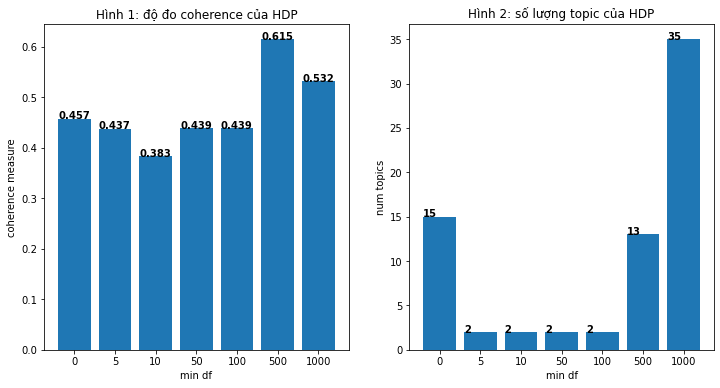

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_ylabel('coherence measure')
axs[0].set_xlabel('min df')
axs[0].set_title('Hình 1: độ đo coherence của HDP')
axs[0].bar(['0', '5', '10', '50', '100', '500', '1000'], [0.45743361738034916,
                                                0.4374798938027368,
                                                0.38297593389709805,
                                                0.4392266051685011,
                                                0.4392266051685011,
                                                0.6151871808420692,
                                                0.5318013264974804], width=0.8)
for i in axs[0].patches: 
    axs[0].text(i.get_x(), i.get_height(),
             '{}'.format(round((i.get_height()), 3)), 
             fontsize = 10, fontweight ='bold', 
             color ='black')


axs[1].bar(['0', '5', '10', '50', '100', '500', '1000'],[15, 2,2,2,2, 13, 35])
axs[1].set_ylabel('num topics')
axs[1].set_xlabel('min df')
axs[1].set_title('Hình 2: số lượng topic của HDP')

for i in axs[1].patches: 
    axs[1].text(i.get_x(), i.get_height(),
             '{}'.format(round((i.get_height()), 3)), 
             fontsize = 10, fontweight ='bold', 
             color ='black')

Lựa chọn initial k cho HDP model

In [14]:
min_df = 500
model_ll_per_word = dict()
num_topic = dict()
alpha=0.1 
eta=0.01
gamma=0.1
init_ks = [10, 50, 100, 200]
for init_k in init_ks:
    hdp = tp.HDPModel(tw=tp.TermWeight.IDF, 
                      min_df=min_df, 
                      initial_k = init_k,
                      alpha=alpha, 
                      eta=eta, 
                      gamma=gamma, 
                      seed=1999)

    for doc in docs:
        hdp.add_doc(doc.words)
    
    hdp.train(0)
    print('init_k:', init_k, 'Num docs:', len(hdp.docs), ', Vocab size:', len(hdp.used_vocabs), ', Num words:', hdp.num_words)
#     print('Removed top words:', hdp.removed_top_words)
    ll_per_word = []
    for i in range(0, 10):
        hdp.train(10)
        print('iteration {}, log likelihood {}, number of topics {}'.format(i, hdp.ll_per_word, hdp.live_k))
        ll_per_word.append(hdp.ll_per_word)
    model_ll_per_word[min_df] = ll_per_word
    num_topic[min_df] = hdp.live_k
    hdp.save('model/hdp_mindf_{}_alpha_{}_eta_{}_gamma_{}_initk_{}.bin'.format(min_df, alpha, eta, gamma, init_k))
    score = eval_coherence(hdp, corpus, vocab, word_list)
    print(init_k, score)

init_k: 10 Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
iteration 0, log likelihood -19.8301049264417, number of topics 15
iteration 1, log likelihood -19.79761264079985, number of topics 16
iteration 2, log likelihood -19.787377043717154, number of topics 16
iteration 3, log likelihood -19.78026775102802, number of topics 18
iteration 4, log likelihood -19.775310666025565, number of topics 17
iteration 5, log likelihood -19.77045323648994, number of topics 17
iteration 6, log likelihood -19.76807303772566, number of topics 15
iteration 7, log likelihood -19.76551178173355, number of topics 15
iteration 8, log likelihood -19.764243830098437, number of topics 16
iteration 9, log likelihood -19.762905565623957, number of topics 15
10 0.6417891635626262
init_k: 50 Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
iteration 0, log likelihood -19.04319003307381, number of topics 52
iteration 1, log likelihood -19.00040073455264, number of topics 52
iteration 2, log likeliho

In [19]:
min_df = 500
model_ll_per_word = dict()
num_topic = dict()
alpha=0.1 
eta=0.01
gamma=0.1
init_ks = [20, 30, 40, 60]
for init_k in init_ks:
    hdp = tp.HDPModel(tw=tp.TermWeight.IDF, 
                      min_df=min_df, 
                      initial_k = init_k,
                      alpha=alpha, 
                      eta=eta, 
                      gamma=gamma, 
                      seed=1999)

    for doc in docs:
        hdp.add_doc(doc.words)
    
    hdp.train(0)
    print('init_k:', init_k, 'Num docs:', len(hdp.docs), ', Vocab size:', len(hdp.used_vocabs), ', Num words:', hdp.num_words)
#     print('Removed top words:', hdp.removed_top_words)
    ll_per_word = []
    for i in range(0, 10):
        hdp.train(10)
        print('iteration {}, log likelihood {}, number of topics {}'.format(i, hdp.ll_per_word, hdp.live_k))
        ll_per_word.append(hdp.ll_per_word)
    model_ll_per_word[min_df] = ll_per_word
    num_topic[min_df] = hdp.live_k
    hdp.save('model/hdp_mindf_{}_alpha_{}_eta_{}_gamma_{}_initk_{}.bin'.format(min_df, alpha, eta, gamma, init_k))
    score = eval_coherence(hdp, corpus, vocab, word_list)
    print(init_k, score)

init_k: 20 Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
iteration 0, log likelihood -19.448262532817207, number of topics 22
iteration 1, log likelihood -19.406002183648816, number of topics 23
iteration 2, log likelihood -19.388844111678715, number of topics 23
iteration 3, log likelihood -19.378695556736048, number of topics 22
iteration 4, log likelihood -19.37376076808675, number of topics 23
iteration 5, log likelihood -19.37019753249122, number of topics 23
iteration 6, log likelihood -19.36860068454412, number of topics 22
iteration 7, log likelihood -19.364687533899957, number of topics 23
iteration 8, log likelihood -19.354777375982202, number of topics 23
iteration 9, log likelihood -19.351891252198456, number of topics 23
20 0.7478287115875623
init_k: 30 Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
iteration 0, log likelihood -19.241942537149963, number of topics 31
iteration 1, log likelihood -19.211987087264873, number of topics 34
iteration 2, log li

In [20]:
min_df = 500
model_ll_per_word = dict()
num_topic = dict()
alpha=0.1 
eta=0.01
gamma=0.1
init_ks = [70, 80, 90]
for init_k in init_ks:
    hdp = tp.HDPModel(tw=tp.TermWeight.IDF, 
                      min_df=min_df, 
                      initial_k = init_k,
                      alpha=alpha, 
                      eta=eta, 
                      gamma=gamma, 
                      seed=1999)

    for doc in docs:
        hdp.add_doc(doc.words)
    
    hdp.train(0)
    print('init_k:', init_k, 'Num docs:', len(hdp.docs), ', Vocab size:', len(hdp.used_vocabs), ', Num words:', hdp.num_words)
#     print('Removed top words:', hdp.removed_top_words)
    ll_per_word = []
    for i in range(0, 10):
        hdp.train(10)
        print('iteration {}, log likelihood {}, number of topics {}'.format(i, hdp.ll_per_word, hdp.live_k))
        ll_per_word.append(hdp.ll_per_word)
    model_ll_per_word[min_df] = ll_per_word
    num_topic[min_df] = hdp.live_k
    hdp.save('model/hdp_mindf_{}_alpha_{}_eta_{}_gamma_{}_initk_{}.bin'.format(min_df, alpha, eta, gamma, init_k))
    score = eval_coherence(hdp, corpus, vocab, word_list)
    print(init_k, score)

init_k: 70 Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
iteration 0, log likelihood -18.892382699481207, number of topics 70
iteration 1, log likelihood -18.862981808390238, number of topics 71
iteration 2, log likelihood -18.849940345276284, number of topics 71
iteration 3, log likelihood -18.843931340758495, number of topics 71
iteration 4, log likelihood -18.840648724448272, number of topics 71
iteration 5, log likelihood -18.83762189161904, number of topics 71
iteration 6, log likelihood -18.834768528969068, number of topics 71
iteration 7, log likelihood -18.83344845740298, number of topics 72
iteration 8, log likelihood -18.83152592472732, number of topics 71
iteration 9, log likelihood -18.83036766421522, number of topics 71
70 0.7432898690342024
init_k: 80 Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
iteration 0, log likelihood -18.905334100233848, number of topics 82
iteration 1, log likelihood -18.858596673870238, number of topics 84
iteration 2, log lik

<Figure size 1080x360 with 0 Axes>

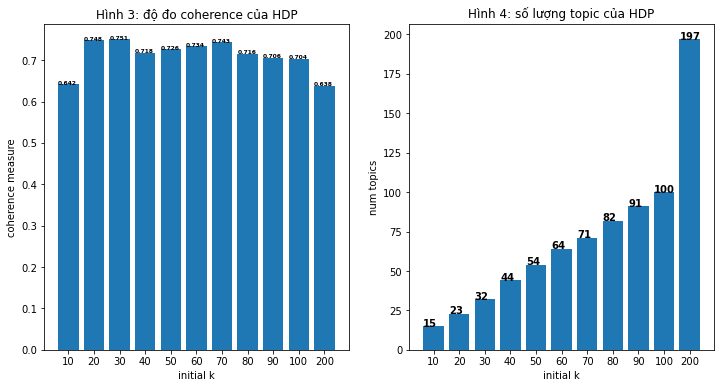

<Figure size 1080x360 with 0 Axes>

In [38]:
x=['10','20','30','40', '50','60', '70','80', '90','100','200']
y=[0.6417891635626262,0.7478287115875623,0.7506879504111312,0.7183323935890105,0.7258059853120962,0.7341802972624092,0.7432898690342024,
 0.7159550767170553,0.7056609641618977,0.7035627709806921, 0.6383539984009747]
z=[15,23,32,44, 54, 64,71,82,91,100,197]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_ylabel('coherence measure')
axs[0].set_xlabel('initial k')
axs[0].set_title('Hình 3: độ đo coherence của HDP')
axs[0].bar(x, y)
for i in axs[0].patches: 
    axs[0].text(i.get_x(), i.get_height(),
             '{}'.format(round((i.get_height()), 3)), 
             fontsize = 6, fontweight ='bold', 
             color ='black')


axs[1].bar(x, z)
axs[1].set_ylabel('num topics')
axs[1].set_xlabel('initial k')
axs[1].set_title('Hình 4: số lượng topic của HDP')

for i in axs[1].patches: 
    axs[1].text(i.get_x(), i.get_height(),
             '{}'.format(round((i.get_height()), 3)), 
             fontsize = 10, fontweight ='bold', 
             color ='black')
plt.figure(figsize=(15, 5))


Huấn luyện HDP model tốt nhất

In [15]:
min_df = 500
alpha=0.1 
eta=0.01
gamma=0.1 # 1 0.5309909242980948 # 10 0.54
init_k = 50

hdp = tp.HDPModel(tw=tp.TermWeight.IDF,
                    min_df=min_df, # min document frequency
                    initial_k=init_k, 
                    alpha=alpha, 
                    eta=eta, 
                    gamma=gamma, 
                    seed=1999)

for doc in docs:
    hdp.add_doc(doc.words)
    
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', len(hdp.used_vocabs), ', Num words:', hdp.num_words)
print('Removed top words:', hdp.removed_top_words)

Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
Removed top words: []


In [16]:
# hdp.burn_in = 100
for i in range(0, 100):
    hdp.train(10)
    print('iteration {}, log likelihood {}, number of topics {}'.format(i, hdp.ll_per_word, hdp.live_k))
    
hdp.save('model/hdp_mindf_{}_alpha_{}_eta_{}_gamma_{}_initk_{}.bin'.format(min_df, alpha, eta, gamma, init_k))
score = eval_coherence(hdp, corpus, vocab, word_list)
print(score)

iteration 0, log likelihood -19.047187380230497, number of topics 52
iteration 1, log likelihood -19.004296243081285, number of topics 54
iteration 2, log likelihood -18.987298799984586, number of topics 54
iteration 3, log likelihood -18.979260084390848, number of topics 54
iteration 4, log likelihood -18.973290090488746, number of topics 55
iteration 5, log likelihood -18.968901650037125, number of topics 55
iteration 6, log likelihood -18.965192970672334, number of topics 56
iteration 7, log likelihood -18.962930176352007, number of topics 56
iteration 8, log likelihood -18.9607530910093, number of topics 55
iteration 9, log likelihood -18.95893548804674, number of topics 55
iteration 10, log likelihood -18.95754982577344, number of topics 56
iteration 11, log likelihood -18.956418497264664, number of topics 56
iteration 12, log likelihood -18.955684103544005, number of topics 56
iteration 13, log likelihood -18.954683214730327, number of topics 56
iteration 14, log likelihood -18.9

In [ ]:
hdp.save('hdp_model.txt')

In [45]:
#coherence measure trên tập test
score = eval_coherence(hdp, test_corpus, test_vocab, test_word_list)
print(score)

0.7198954073876153


In [47]:
# thông tin HDP model
hdp.summary()

<Basic Info>
| HDPModel (current version: 0.9.1)
| 41516 docs, 7207808 words
| Total Vocabs: 186672, Used Vocabs: 2380
| Entropy of words: -7.33897
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -18.93663
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 0 (minimum collection frequency of words)
| min_df: 500 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| initial_k: 50 (the initial number of topics between 2 ~ 32767 The number of topics will be adjusted for data during training)
| alpha: 0.1 (concentration coeficient of Dirichlet Process for document-table )
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| gamma: 0.1 (concentration coeficient of Dirichlet Process for table-topic)
| seed: 1999 (random seed)
| trained in version 0.9.1
|
<Parameters>
| alpha (concentration coeficient of Dirichlet Process for document-table)
|  0.0073

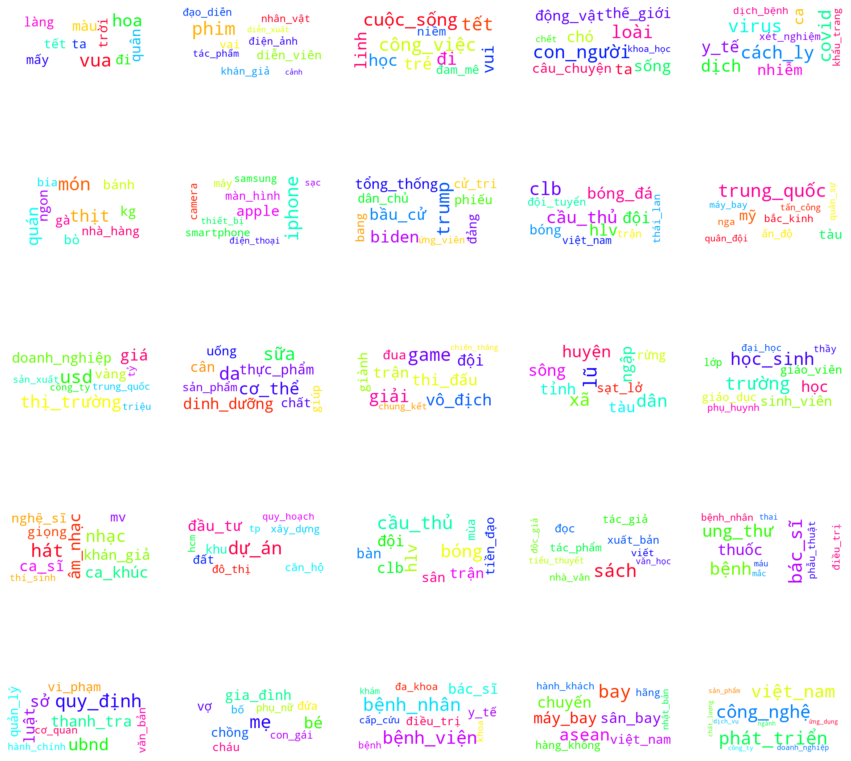

In [48]:
# các chủ đề của LDA wordcloud
fig, ax = plt.subplots(5, 5, figsize = (15, 15))
for i in range(0,25):
    topic = lda.get_topic_words(i, top_n=10)
    dictionary = dict(topic)
    cloud = WordCloud(max_font_size=50, colormap="hsv", 
                      background_color="white").generate_from_frequencies(dictionary)
    ax[i//5, i%5].imshow(cloud, interpolation='bilinear')
    ax[i//5, i%5].axis('off')
#     ax[i//5, i%5].set_title(classNames[trainY[sample]])    

plt.show()

In [38]:
# so sánh count vector với TF-IDF vector
min_df = 500
k = 40
alpha = 0.1
eta = 0.01
lda = tp.LDAModel(tw=tp.TermWeight.IDF,
                    min_df=min_df, # min document frequency
                    k=k,
                    alpha=alpha, 
                    eta=eta, 
                    seed=1999)

for doc in docs:
    lda.add_doc(doc.words)
    
lda.train(0)
print('Num docs:', len(lda.docs), ', Vocab size:', len(lda.used_vocabs), ', Num words:', lda.num_words)
print('Removed top words:', lda.removed_top_words)
for i in range(0, 10):
    lda.train(10)
    print('iteration {}, log likelihood {}'.format(i, lda.ll_per_word))
    
lda.save('model/lda_model_k_{}_twIDF.txt'.format(k))
score = eval_coherence_lda(lda, corpus, vocab, word_list)
print('IDF',k, score)

lda = tp.LDAModel(tw=tp.TermWeight.ONE,
                    min_df=min_df, # min document frequency
                    k=k,
                    alpha=alpha, 
                    eta=eta, 
                    seed=1999)

for doc in docs:
    lda.add_doc(doc.words)
    
lda.train(0)
print('Num docs:', len(lda.docs), ', Vocab size:', len(lda.used_vocabs), ', Num words:', lda.num_words)
print('Removed top words:', lda.removed_top_words)
for i in range(0, 10):
    lda.train(10)
    print('iteration {}, log likelihood {}'.format(i, lda.ll_per_word))
    
lda.save('model/lda_model_k_{}_twONE.txt'.format(k))
score = eval_coherence_lda(lda, corpus, vocab, word_list)
print('ONE',k, score)

Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
Removed top words: []
iteration 0, log likelihood -24.725841533552813
iteration 1, log likelihood -23.516726659719673
iteration 2, log likelihood -23.239771073338012
iteration 3, log likelihood -23.105268912051113
iteration 4, log likelihood -23.02001780792505
iteration 5, log likelihood -22.952308326320804
iteration 6, log likelihood -22.900263715384785
iteration 7, log likelihood -22.85718285532318
iteration 8, log likelihood -22.82088484468209
iteration 9, log likelihood -22.78475030857472
IDF 40 0.7818085592129056
Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
Removed top words: []
iteration 0, log likelihood -7.922784440551136
iteration 1, log likelihood -7.384296948830896
iteration 2, log likelihood -7.253502853964105
iteration 3, log likelihood -7.198411019198594
iteration 4, log likelihood -7.167909365596833
iteration 5, log likelihood -7.1480378058441225
iteration 6, log likelihood -7.136520897727319
iteration 7,

Text(0.5, 1.0, 'LDA')

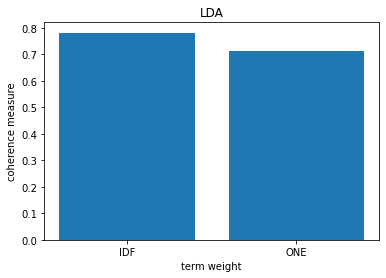

In [39]:
plt.bar(['IDF', 'ONE'], [0.7818085592129056,0.7140312129646906])
plt.xlabel('term weight')
plt.ylabel('coherence measure')
plt.title('Hình 6: độ đo coherence của LDA')

Lựa chọn k cho LDA model

In [17]:
ks = [10, 50, 100, 200]
min_df = 500
alpha=0.1 
eta=0.01
for k in ks:
    lda = tp.LDAModel(tw=tp.TermWeight.IDF,
                    min_df=min_df, # min document frequency
                    k=k,
                    alpha=alpha, 
                    eta=eta, 
                    seed=1999)

    for doc in docs:
        lda.add_doc(doc.words)
    
    lda.train(0)
    print('k:', k, 'Num docs:', len(lda.docs), ', Vocab size:', len(lda.used_vocabs), ', Num words:', lda.num_words)
#     print('Removed top words:', lda.removed_top_words)
    for i in range(0, 10):
        lda.train(10)
        print('iteration {}, log likelihood {}'.format(i, lda.ll_per_word))
    
    lda.save('model/lda_model_k_{}.txt'.format(k))
    score = eval_coherence_lda(lda, corpus, vocab, word_list)
    print(k, score)

k: 10 Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
iteration 0, log likelihood -24.788270901213178
iteration 1, log likelihood -23.56138020388299
iteration 2, log likelihood -23.282925230252104
iteration 3, log likelihood -23.185666607186867
iteration 4, log likelihood -23.133997846099344
iteration 5, log likelihood -23.099782428068814
iteration 6, log likelihood -23.077196803881876
iteration 7, log likelihood -23.061745766010667
iteration 8, log likelihood -23.047324763268577
iteration 9, log likelihood -23.033501831230904
10 0.7719490512805559
k: 50 Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
iteration 0, log likelihood -24.641918346464244
iteration 1, log likelihood -23.462276504066566
iteration 2, log likelihood -23.20095858547095
iteration 3, log likelihood -23.070446265214173
iteration 4, log likelihood -22.98432469955544
iteration 5, log likelihood -22.918776661817866
iteration 6, log likelihood -22.863532175999392
iteration 7, log likelihood -22.815405484

In [18]:
ks = [20, 30, 40, 60]
min_df = 500
alpha=0.1 
eta=0.01
for k in ks:
    lda = tp.LDAModel(tw=tp.TermWeight.IDF,
                    min_df=min_df, # min document frequency
                    k=k,
                    alpha=alpha, 
                    eta=eta, 
                    seed=1999)

    for doc in docs:
        lda.add_doc(doc.words)
    
    lda.train(0)
    print('k:', k, 'Num docs:', len(lda.docs), ', Vocab size:', len(lda.used_vocabs), ', Num words:', lda.num_words)
#     print('Removed top words:', lda.removed_top_words)
    for i in range(0, 10):
        lda.train(10)
        print('iteration {}, log likelihood {}'.format(i, lda.ll_per_word))
    
    lda.save('model/lda_model_k_{}.txt'.format(k))
    score = eval_coherence_lda(lda, corpus, vocab, word_list)
    print(k, score)

k: 20 Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
iteration 0, log likelihood -24.433663302621305
iteration 1, log likelihood -23.33552099209543
iteration 2, log likelihood -23.11569366309454
iteration 3, log likelihood -23.021910903488592
iteration 4, log likelihood -22.960295474050785
iteration 5, log likelihood -22.915695827682136
iteration 6, log likelihood -22.881072847223283
iteration 7, log likelihood -22.852880145849063
iteration 8, log likelihood -22.824267479261188
iteration 9, log likelihood -22.804524017059617
20 0.7700569673346745
k: 30 Num docs: 41478 , Vocab size: 2380 , Num words: 7207704
iteration 0, log likelihood -24.544063296264934
iteration 1, log likelihood -23.410721946221088
iteration 2, log likelihood -23.152485669892915
iteration 3, log likelihood -23.031571884404723
iteration 4, log likelihood -22.952393088063165
iteration 5, log likelihood -22.892015576219165
iteration 6, log likelihood -22.8474054147773
iteration 7, log likelihood -22.8126426749

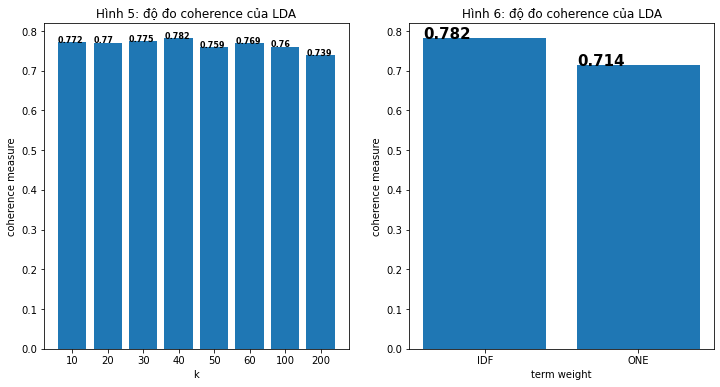

In [40]:

x = ['10','20','30','40','50','60','100','200']
y = [0.7719490512805559,0.7700569673346745,0.7746342585712457,0.7818085592129056,0.7589821349785321,0.7694212201825225, 0.7604470622060377,0.738590339429848]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_ylabel('coherence measure')
axs[0].set_xlabel('k')
axs[0].set_title('Hình 5: độ đo coherence của LDA')
axs[0].bar(x, y)
for i in axs[0].patches: 
    axs[0].text(i.get_x(), i.get_height(),
             '{}'.format(round((i.get_height()), 3)), 
             fontsize = 8, fontweight ='bold', 
             color ='black')


axs[1].bar(['IDF', 'ONE'], [0.7818085592129056,0.7140312129646906])
axs[1].set_ylabel('coherence measure')
axs[1].set_xlabel('term weight')
axs[1].set_title('Hình 6: độ đo coherence của LDA')

for i in axs[1].patches: 
    axs[1].text(i.get_x(), i.get_height(),
             '{}'.format(round((i.get_height()), 3)), 
             fontsize = 15, fontweight ='bold', 
             color ='black')


In [ ]:
for i in range(0, 500):
    lda.train(1)
    print('iteration {}, log likelihood {}'.format(i, lda.ll_per_word))

In [ ]:
import pyLDAvis

def visualize(mdl, direc):
    def zz(inp):
        return np.array(inp)/sum(inp)
    topic_term_dists = np.stack([zz(mdl.get_topic_word_dist(k)) for k in range(mdl.k)])
    doc_topic_dists = np.stack([zz(doc.get_topic_dist()) for doc in mdl.docs])
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq
    print(doc_topic_dists.shape)
    print(topic_term_dists.shape)
    prepared_data = pyLDAvis.prepare(
        topic_term_dists, 
        doc_topic_dists, 
        doc_lengths, 
        vocab, 
        term_frequency
    )
    pyLDAvis.save_html(prepared_data, direc)
    
visualize(lda, 'lda400vis.html')

In [14]:
clusters = get_clusters(hdp)

870 272 1047 841 789 714 1411 634 814 291 996 807 2669 1221 634 626 781 813 1132 911 1737 1340 432 258 1091 1206 712 218 289 432 772 661 182 788 895 397 1478 1212 1004 610 406 261 566 971 581 676 337 878 1882 968 1 2 0 0 

In [42]:
# hiển thị các cụm của LDA

def visualize(mdl, direc):
    def zz(inp):
        return np.array(inp)/sum(inp)
    topic_term_dists = np.stack([zz(mdl.get_topic_word_dist(k)) for k in range(mdl.k)])
    doc_topic_dists = np.stack([zz(doc.get_topic_dist()) for doc in mdl.docs])
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq
    print(doc_topic_dists.shape)
    print(topic_term_dists.shape)
    prepared_data = pyLDAvis.prepare(
        topic_term_dists, 
        doc_topic_dists, 
        doc_lengths, 
        vocab, 
        term_frequency
    )
    pyLDAvis.save_html(prepared_data, direc)
    
visualize(lda, 'ldavis_40.html')

(41478, 40)
(40, 2380)


<BarContainer object of 40 artists>

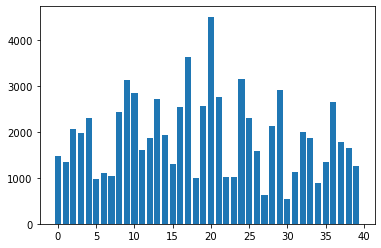

In [15]:
# Phân bố các văn bản theo chủ đề
x = [1488, 1353, 2076, 1988, 2306, 971, 1104, 1049, 2448, 3142, 2855, 1621, 1862, 2731, 1929, 1314, 2555, 3634, 994, 2560, 4518, 2762, 1011, 1024, 3167, 2307, 1592, 637, 2138, 2917, 548, 1135, 2008, 1871, 888, 1358, 2668, 1790, 1646, 1261]
plt.bar(np.arange(40),x)

In [16]:
print(np.mean(x))

1930.65
